In [9]:
import collections
import numpy as np
import scipy.optimize

tax_rates = [
    (9700, 0.10),
    (39475, 0.12),
    (84200, 0.22),
    (160725, 0.24),
    (204100, 0.32),
    (510300, 0.35),
    (1000**5, 0.37)
]

ca_tax_rates = [
    (8544, 0.01),
    (20255, 0.02),
    (31969, 0.04),
    (44377, 0.06),
    (56085, 0.08),
    (286492, 0.093),
    (343788, 0.103),
    (572980, 0.113),
    (1000**5, 0.123)
]

example_tax_rates = [ # Example 4% on some income, just because, representing some arbitrary state that's not CA
    (10000, 0.01),
    (40000, 0.02),
    (80000, 0.03),
    (1000**5, 0.04)
]

def incometax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [incometax(i, state_tax=state_tax) for i in pretax_income_arg]
    tax_owed = 0
    previous_end = 0
    pretax_income = pretax_income_arg - 12200 # Standard Exemption
    for end, rate in tax_rates:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    for end, rate in state_tax:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    return round(tax_owed,0)

def posttax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [posttax(i, state_tax=state_tax) for i in pretax_income_arg]
    return round(pretax_income_arg - incometax(pretax_income_arg, state_tax=state_tax),0)

def pretax(posttax_income, state_tax=[]):
    if isinstance(posttax_income, collections.Iterable):
        return [pretax(i, state_tax=state_tax, quiet=quiet) for i in posttax_income]
    pretax_error = lambda pretax_income : posttax(pretax_income, state_tax=state_tax) - posttax_income
    # Use a Brent gradient approach method of solving roots to determine the proper value
    pretax_income = scipy.optimize.brentq(pretax_error, 0, posttax_income * 100)
    return round(pretax_income,1)

    

Pretax Income ranging from 0 to 340000


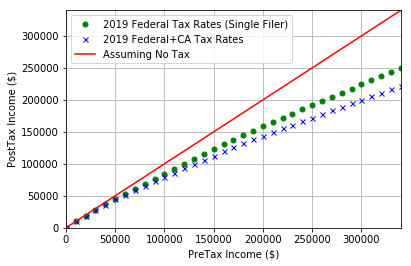

In [10]:
import matplotlib.pyplot as plt

pretax_income = np.arange(0, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax(pretax_income, state_tax=[]), 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, posttax(pretax_income, state_tax=ca_tax_rates), 'xb', ms=5, label='2019 Federal+CA Tax Rates')
plt.plot(pretax_income, pretax_income, '-r', ms=4, label='Assuming No Tax')
plt.axis([0,pretax_income[-1],0,pretax_income[-1]])
plt.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('PostTax Income ($)')
plt.grid()

plt.show()


Pretax Income ranging from 75000 to 345000
Avg approx error is 0.0038
Polynomial terms are [-4.94625324e-07  8.94925918e-01]


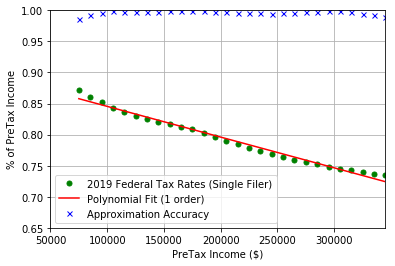

In [104]:
pretax_income = np.arange(75 * 1000, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)
posttax_income_as_percent = posttax_income/pretax_income
polyfit_order = 1
approx_percent_polynom = np.poly1d(np.polyfit(pretax_income, posttax_income/pretax_income, polyfit_order))
approx_percent = approx_percent_polynom(pretax_income)
approximation_error = [abs(x-y) for x, y  in zip(approx_percent, posttax_income_as_percent)]
avg_approx_error = np.average(approximation_error)
approximation_accuracy = [1-x for x in approximation_error]

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))
print('Avg approx error is {:.2}'.format(avg_approx_error))
print('Polynomial terms are {}'.format(np.asarray(approx_percent_polynom)))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income_as_percent, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, approx_percent, '-r', ms=5, label='Polynomial Fit ({} order)'.format(polyfit_order))
plt.plot(pretax_income, approximation_accuracy, 'xb', ms=5, label='Approximation Accuracy')
plt.axis([50000,pretax_income[-1],0.65,1])
plt.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('% of PreTax Income')
plt.grid()
plt.show()


In [32]:
import sys
class RecurringCashflow:
    def define_monthly(self, monthly_flow, name, monthly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=True):
        self.define_yearly(monthly_flow * 12, name, monthly_nw*12, yearly_apr, year_start, year_end, taxable)
        return self
        
    def define_yearly(self, yearly_flow, name, yearly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=True):
        self.yearly_flow = yearly_flow
        self.name = name
        self.yearly_nw = yearly_nw
        self.yearly_apr = yearly_apr
        self.year_start = year_start
        self.year_end = year_end
        self.taxable = taxable
        return self
    
    def cashflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
        
    def gross_income(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow > 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def taxable_income(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow > 0 and self.taxable:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def expenses(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow < 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def nwflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_nw * (self.yearly_apr**years_accumulated)
        else:
            return 0

        
class CashflowModel():
    def __init__(self, name='Unnamed'):
        self.cashflows = []
        self.name = name
        
    def add_recurring_cashflow(self, recurring_cashflow):
        self.cashflows.append(recurring_cashflow)
        
    def add_monthly(self, *args, **kwargs):
        rc = RecurringCashflow().define_monthly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def add_yearly(self, *args, **kwargs):
        rc = RecurringCashflow().define_yearly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def get_cashflow(self, year):
        return sum([x.cashflow(year) for x in self.cashflows])
    
    def get_gross_income(self, year):
        return sum([x.gross_income(year) for x in self.cashflows])
    
    def get_taxable_income(self, year):
        return sum([x.taxable_income(year) for x in self.cashflows])
    
    def get_expenses(self, year):
        return sum([x.expenses(year) for x in self.cashflows])
        
    def get_nwflow(self, year):
        return sum([x.nwflow(year) for x in self.cashflows])
    
    def plot_annual_flow(self, year=0):
        fig = plt.figure(figsize=(14,5))
        plt.suptitle('Annual Cashflows for $\it{}$'.format(self.name))
        plt.subplot(1,2,1)
        cashflow_list = [(x.cashflow(year)) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Annual Cashflows (${})'.format(self.get_cashflow(year)))
        plt.subplot(1,2,2)
        nwflow_list = [x.nwflow(year) for x in self.cashflows]
        nwflow_labels = [x.name +' (${})'.format(int(x.nwflow(year))) if x.yearly_nw != 0 else '' for x in self.cashflows]
        plt.pie(nwflow_list, labels=nwflow_labels)
        plt.title('Yearly NW Flow (${})'.format(int(sum([x.nwflow(year) for x in self.cashflows]))))
        fig.tight_layout()
        plt.show()
        
    def plot_monthly_flow(self, year=0):
        fig = plt.figure(figsize=(14,5))
        plt.suptitle('Monthly Cashflows for $\it{}$'.format(self.name))
        plt.subplot(1,2,1)
        cashflow_list = [int(x.cashflow(year)/12) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y/12)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        plt.title('Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        plt.subplot(1,2,2)
        monthly_nwflow_list = [x.nwflow(year)/12 for x in self.cashflows]
        monthly_nwflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows,monthly_nwflow_list)]
        plt.pie(monthly_nwflow_list, labels=monthly_nwflow_labels)
        plt.title('Monthly NW Flow (${})'.format(int(sum(monthly_nwflow_list))))
        fig.tight_layout()
        plt.show()




In [33]:
import pandas as pd
import copy

# We create a list of dictionaries, where each entry/dict is one row

class FinancialModel:
    # A Financial Model takes in initial conditions and a CashflowModel, creating a time history of key metrics:
    # Total Net Worth, Annual Outflows, Annual NW Increase, Annual Pretax Required, and Year ID
    # These are returned in a dataframe by 'sim', then passed to plotting/analysis/stored
    
    def sim_basic(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr=1.07):
        return self.sim(cashflowmodel, nyears=nyears, initial_nw=initial_nw, nw_apr_avg=nw_apr, nw_apr_stdev=0, nruns=1)
        
        
        
        year_dict = {}
        year_dict['Annual NW Flow'] = 0
        year_dict['Total Net Worth'] = initial_nw
        year_dict['Annual Cashflow'] = 0
        year_dict['Annual Expenses'] = 0
        year_dict['nw_apr'] = nw_apr
        year_dict['Year ID'] = 0
        years = []
        years.append(copy.deepcopy(year_dict))
        last_year = copy.deepcopy(year_dict)
        for current_year_id in np.arange(1,nyears):
            # Each year, we increase our networth by some percentage due to asset appreciation
            # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
            year_dict['Annual NW Flow'] = cashflowmodel.get_nwflow(current_year_id)
            year_dict['Total Net Worth'] = round(last_year['Total Net Worth'] * nw_apr + year_dict['Annual NW Flow'],0)
            year_dict['Annual Cashflow'] = cashflowmodel.get_cashflow(current_year_id)
            year_dict['Annual Expenses'] = cashflowmodel.get_expenses(current_year_id)
            year_dict['nw_apr'] = nw_apr
            year_dict['Year ID'] = current_year_id
            last_year = copy.deepcopy(year_dict)
            years.append(last_year)
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {} for {} yrs'.format(cashflowmodel.name, initial_nw, nw_apr, nyears))
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr
        return (pd.DataFrame(years), df_summary)
    
    def sim(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr_avg=1.07, nw_apr_stdev=1.07*0.50, nruns=25):
        sim_run_dfs = []
        for run in np.arange(0,nruns): # should use >= 100 runs for some statistical interest
            year_dict = {}
            year_dict['Annual NW Flow'] = 0
            year_dict['Total Net Worth'] = initial_nw
            year_dict['Annual Cashflow'] = 0
            year_dict['Annual Expenses'] = 0
            year_dict['nw_apr'] = nw_apr_avg
            year_dict['Year ID'] = 0
            year_dict['Sim Run'] = run
            years = []
            years.append(copy.deepcopy(year_dict))
            last_year = copy.deepcopy(year_dict)
            for current_year_id in np.arange(1,nyears):
                # Each year, we increase our networth by some percentage due to asset appreciation
                # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
                nw_apr = np.random.normal(loc = nw_apr_avg, scale = nw_apr_stdev, size = 1)[0]
                year_dict['Annual NW Flow'] = cashflowmodel.get_nwflow(current_year_id)
                year_dict['Total Net Worth'] = round(last_year['Total Net Worth'] * nw_apr + year_dict['Annual NW Flow'],0)
                year_dict['Annual Cashflow'] = cashflowmodel.get_cashflow(current_year_id)
                year_dict['Annual Expenses'] = cashflowmodel.get_expenses(current_year_id)
                year_dict['nw_apr'] = nw_apr
                year_dict['Year ID'] = current_year_id
                last_year = copy.deepcopy(year_dict)
                years.append(last_year)
            sim_run_dfs.append(pd.DataFrame(years))
        # We now have a list of DataFrames to process... 
        all_dfs = pd.concat(sim_run_dfs)
        year_summary = {}
        years = []
        for current_year_id in np.arange(1, nyears):
            this_years_rows = [df.loc[df['Year ID'] == current_year_id] for df in sim_run_dfs]
            this_years_rows = pd.concat(this_years_rows)
            year_summary['Annual NW Flow'] = np.mean(this_years_rows['Annual NW Flow'].tolist())
            year_summary['Annual NW Flow:STDEV'] = np.std(this_years_rows['Annual NW Flow'])
            year_summary['Total Net Worth'] = np.mean(this_years_rows['Total Net Worth'])
            year_summary['Total Net Worth:STDEV'] = np.std(this_years_rows['Total Net Worth'])
            year_summary['Annual Cashflow'] = np.mean(this_years_rows['Annual Cashflow'])
            year_summary['Annual Cashflow:STDEV'] = np.std(this_years_rows['Annual Cashflow'])
            year_summary['Annual Expenses'] = np.mean(this_years_rows['Annual Expenses'])
            year_summary['Annual Expenses:STDEV'] = np.std(this_years_rows['Annual Expenses'])
            year_summary['nw_apr'] = np.mean(this_years_rows['nw_apr'])
            year_summary['nw_apr:STDEV'] = np.std(this_years_rows['nw_apr'])
            year_summary['Year ID'] = np.mean(this_years_rows['Year ID'])
            year_summary['Year ID:STDEV'] = np.std(this_years_rows['Year ID'])
            this_year = copy.deepcopy(year_summary)
            years.append(this_year)
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {}+/-{} for {} yrs'.format(cashflowmodel.name, initial_nw, nw_apr_avg, nw_apr_stdev, nyears))
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr_avg
        df_summary['nw_apr_stdev'] = nw_apr_stdev
        return (pd.DataFrame(years), df_summary)
    
    def plot(self, df_tuple):
        fig = plt.figure(figsize=(8,6))
        plt.subplot(1,1,1)
        ax = plt.gca()
        if isinstance(df_tuple, list):
            df_tuple_list = df_tuple
        else:
            df_tuple_list = [df_tuple]
        for df, df_summary in df_tuple_list:
            error_bars = df['Total Net Worth:STDEV'] if 'Total Net Worth:STDEV' in df.columns else 0
            plt.errorbar(df['Year ID'], df['Total Net Worth'], yerr=error_bars, capsize=7, ms=5, label='Total Net Worth ({})'.format(df_summary['name']))
        plt.legend()
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Years Since Initial Conditions')
        ax.set_ylabel('Total Net Worth (Current Value $)')
        plt.grid()
        plt.show()

remaining = 332176.0


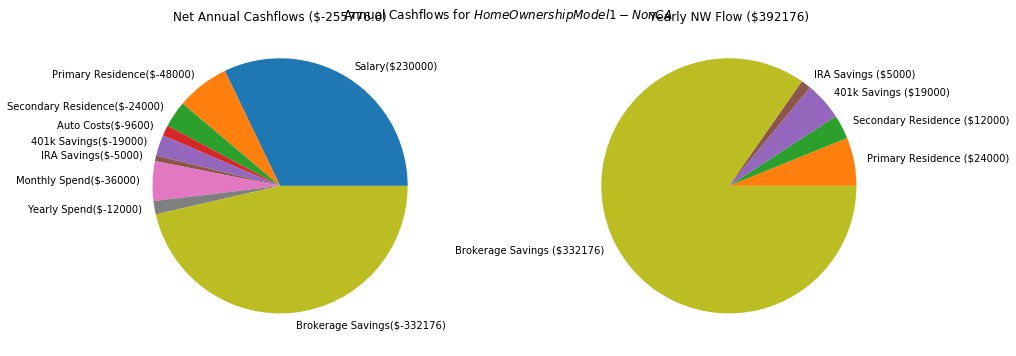

remaining = 467476.0


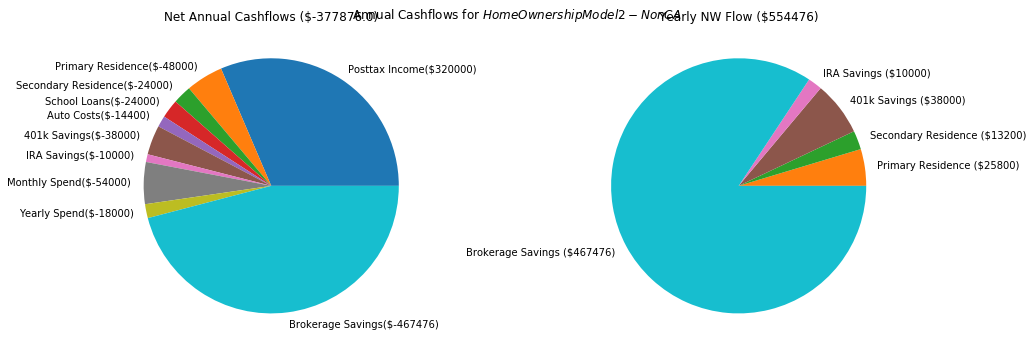

remaining = 303988.0


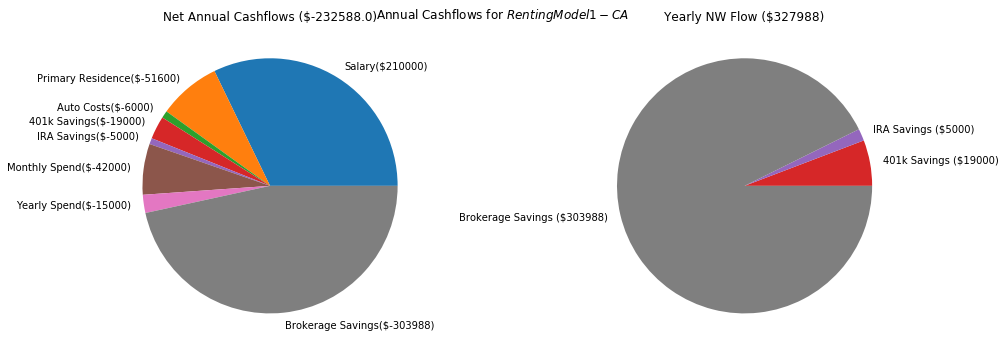

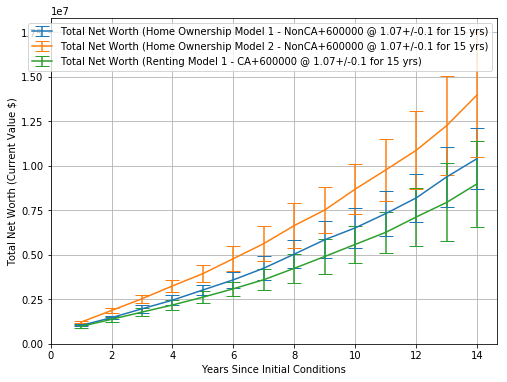

In [39]:
cur_state = FinancialModel()

cm = CashflowModel('Home Ownership Model 1 - NonCA') #Home Ownership Model (as compared to renting, etc)
cm.add_yearly(230000, 'Salary')
cm.add_monthly(-4000, 'Primary Residence', monthly_nw=2000)
cm.add_monthly(-2000, 'Secondary Residence', monthly_nw=1000)
cm.add_monthly(-800, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')
# At this point, the annual cashflow left can go into the brokerage
remaining_income = posttax(cm.get_taxable_income(0)) - cm.get_expenses(0)
print('remaining = {}'.format(remaining_income))
cm.add_yearly(-remaining_income, 'Brokerage Savings', yearly_nw=remaining_income)

cm.plot_annual_flow()
#ho_model.plot_monthly_flows()

sim_results = []
#sim_results.append(cur_state.sim(cm, nyears=15, initial_nw=600000, nw_apr=1.05))
#sim_results.append(cur_state.sim(cm, nyears=15, initial_nw=600000, nw_apr=1.09))
sim_results.append(cur_state.sim(cm, nyears=15, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.10))
#cur_state.plot(sim_results)

cm = CashflowModel('Home Ownership Model 2 - NonCA') #Home Ownership Model (as compared to renting, etc)
cm.add_yearly(230000 + 90000, 'Posttax Income')
cm.add_monthly(-4000, 'Primary Residence', monthly_nw=2150)
cm.add_monthly(-2000, 'Secondary Residence', monthly_nw=1100)
cm.add_monthly(-2000, 'School Loans')
cm.add_monthly(-1200, 'Auto Costs')
cm.add_yearly(-38000, '401k Savings', yearly_nw=38000)
cm.add_yearly(-10000, 'IRA Savings', yearly_nw=10000)
cm.add_monthly(-4500, 'Monthly Spend')
cm.add_yearly(-18000, 'Yearly Spend')
# At this point, the annual cashflow left can go into the brokerage
remaining_income = posttax(cm.get_taxable_income(0)) - cm.get_expenses(0)
print('remaining = {}'.format(remaining_income))
cm.add_yearly(-remaining_income, 'Brokerage Savings', yearly_nw=remaining_income)
cm.plot_annual_flow()
sim_results.append(cur_state.sim(cm, nyears=15, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.10))

cm = CashflowModel('Renting Model 1 - CA')
pretax_income = 210000
cm.add_yearly(pretax_income, 'Salary')
cm.add_monthly(-4300, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-500, 'Auto Costs')
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000)
cm.add_monthly(-3500, 'Monthly Spend') # CA is expensive
cm.add_yearly(-15000, 'Yearly Spend')
# At this point, the annual cashflow left can go into the brokerage
remaining_income = posttax(cm.get_taxable_income(0)) - cm.get_expenses(0)
print('remaining = {}'.format(remaining_income))
cm.add_yearly(-remaining_income, 'Brokerage Savings', yearly_nw=remaining_income)
cm.plot_annual_flow()

sim_results.append(cur_state.sim(cm, nyears=15, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.10))

cur_state.plot(sim_results)

